# Data Science dla studentów MBA Digital Transformation
## dr inż Marcin Luckner
### marcin.luckner@pw.edu.pl

## Cel zajęć

Celem zajęć jest zapoznanie uczestników z zagadnieniami klasyfikacji, regresji i klasteryzacji wykorzystując rzeczywiste dane. Do analizy danych użyty został język R (http://www.biecek.pl/R/#Pogromcy).

## Instalacja pakietów

Ponieważ jest to czasochłonne, zainstalujmy na początku pakiety, które będą nam potrzebne podczas zajęć, a które nie są domyślnie zainstalowane w środowisku.

In [1]:
install.packages("e1071")
install.packages("caret")
install.packages("rpart.plot")
install.packages("randomForest")


Pobrane pakiety binarne są w
	/var/folders/j3/y5z3fdtd55zgwg4h1_43ns2w0000gn/T//RtmpIC6Fzm/downloaded_packages

Pobrane pakiety binarne są w
	/var/folders/j3/y5z3fdtd55zgwg4h1_43ns2w0000gn/T//RtmpIC6Fzm/downloaded_packages

Pobrane pakiety binarne są w
	/var/folders/j3/y5z3fdtd55zgwg4h1_43ns2w0000gn/T//RtmpIC6Fzm/downloaded_packages

Pobrane pakiety binarne są w
	/var/folders/j3/y5z3fdtd55zgwg4h1_43ns2w0000gn/T//RtmpIC6Fzm/downloaded_packages


## Opis danych

Dane pochodzą z brytyjskiej agencji autostrad i zawierają rzeczywiste dane dotyczące przemieszczania się pojazdów pomiędzy skrzyżowaniami sieci autostrad.

### Struktura danych:

* #LinkRef - Unikalny identyfikator połączenia reprezentujący połączenie między skrzyżowaniami w sieci dróg zarządzanej przez Agencję Autostrad.
* #LinkDescription - Opis połączenia.
* #Date - data podróży.
* #TimePeriod - Jeden z 96 15-minutowych przedziałów w ciągu dnia, do których odnoszą się dane (0-95, gdzie 0 oznacza 00:00 do 00:15). 
* #AverageJT - Średni czas przejazdu przez połączenie w sekundach, dla pojazdów wjeżdżających na połączenie między skrzyżowaniami w danym 15-minutowym okresie czasu.
* #AverageSpeed - Średnia prędkość (w km/h) pojazdów wjeżdżających na połączenie między węzłami w danym 15-minutowym przedziale czasu.
* #DataQuality - Wskaźnik pokazujący jakość danych o czasie przejazdu dla danego połączenia i okresu czasu. 1 oznacza najwyższą jakość danych, a 5 - najniższą.
* #LinkLength -Długość połączenia (km).
* #Flow - Średnia z zaobserwowanego przepływu dla danego połączenia, okresu czasu i typu dnia. 

## Wczytanie danych:

Wczytanie pliku z danymi z lutego 2015 roku:

In [2]:
path = "./Data/"
filename = "FEB15.csv"
probe = read.csv(unzip(paste(path,filename,".zip",sep=''),filename))

Do przetwarzania danych korzystając z wygodnej notacji strumieniowej użyjemy bibliotek _plyr_ i _dplyr_ (http://genomicsclass.github.io/book/pages/dplyr_tutorial.html):

In [3]:
  require(plyr)
  require(dplyr)

Ładowanie wymaganego pakietu: plyr

Ładowanie wymaganego pakietu: dplyr


Dołączanie pakietu: ‘dplyr’


Następujące obiekty zostały zakryte z ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Następujące obiekty zostały zakryte z ‘package:stats’:

    filter, lag


Następujące obiekty zostały zakryte z ‘package:base’:

    intersect, setdiff, setequal, union




Usunięcie z danych zbędnej kolumny zawierającej opis i ograniczenie danych do rekordów o najlepszej jakości:

In [4]:
  probe <- probe %>%
   filter(DataQuality == 1) %>%
   select(-LinkDescription)

Dodanie informacji o godzinie przejazdu:

In [5]:
  probe$Hour = as.integer(probe$TimePeriod*15/60)

Dodanie informacji o dniu tygodnia przejazdu:

In [6]:
  Sys.setlocale("LC_TIME", "en_US")
  probe$DayOfWeek = weekdays(as.Date(probe$Date))

  dow  = c("Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday", "Sunday")
  probe$DayOfWeek = factor(probe$DayOfWeek,levels=dow,ordered=TRUE)

[1] "en_US"

Wczytane dane:

In [7]:
head(probe)

,LinkRef,Date,TimePeriod,AverageJT,AverageSpeed,DataQuality,LinkLength,Flow,Hour,DayOfWeek
,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<ord>
1,AL215,2015-02-10 00:00:00,67,305.47,105.12,1,8.92,286.50,16,Tuesday
2,AL215,2015-02-10 00:00:00,68,289.30,111.00,1,8.92,291.63,17,Tuesday
3,AL215,2015-02-10 00:00:00,69,330.17,97.26,1,8.92,291.63,17,Tuesday
4,AL215,2015-02-10 00:00:00,70,308.21,104.19,1,8.92,291.63,17,Tuesday
5,AL215,2015-02-10 00:00:00,71,321.99,99.73,1,8.92,291.63,17,Tuesday
6,AL215,2015-02-10 00:00:00,72,305.92,104.97,1,8.92,186.13,18,Tuesday


## Eksploracja danych

Przegląd statystyk dla prędkości przejazu w poszczególnych dniach tygodnia:

In [8]:
statistics <- probe %>% 
  group_by(DayOfWeek)%>%
  summarise(avg_speed = mean(AverageSpeed), 
            min_speed = min(AverageSpeed),
            max_speed = max(AverageSpeed),
            total = n())
View(statistics)

DayOfWeek,avg_speed,min_speed,max_speed,total
<ord>,<dbl>,<dbl>,<dbl>,<int>
Monday,94.07678,7.99,157.18,48160
Tuesday,93.90507,9.82,152.50,48584
Wednesday,93.96368,9.51,165.34,48824
Thursday,93.46748,6.67,155.58,49033
Friday,94.72543,8.83,168.00,48497
Saturday,98.65267,11.45,186.30,45750
Sunday,99.28024,32.60,169.19,42647


### Wizualizacje

W celu zaprezentowania danych użyjemy biblioteki _ggplot2_ (http://tutorials.iq.harvard.edu/R/Rgraphics/Rgraphics.html):

In [9]:
require(ggplot2)

Ładowanie wymaganego pakietu: ggplot2



Rozkład średnich prędkości w zależności od dnia tygodnia:

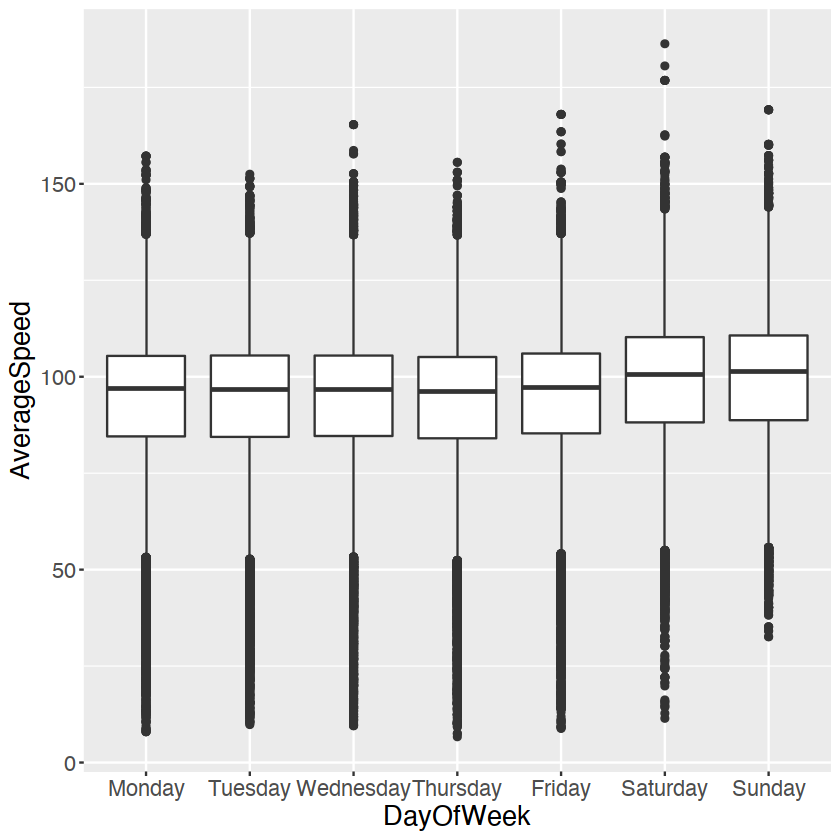

In [10]:
ggplot(probe, aes(DayOfWeek,AverageSpeed)) + geom_boxplot()+theme(text = element_text(size = 16))

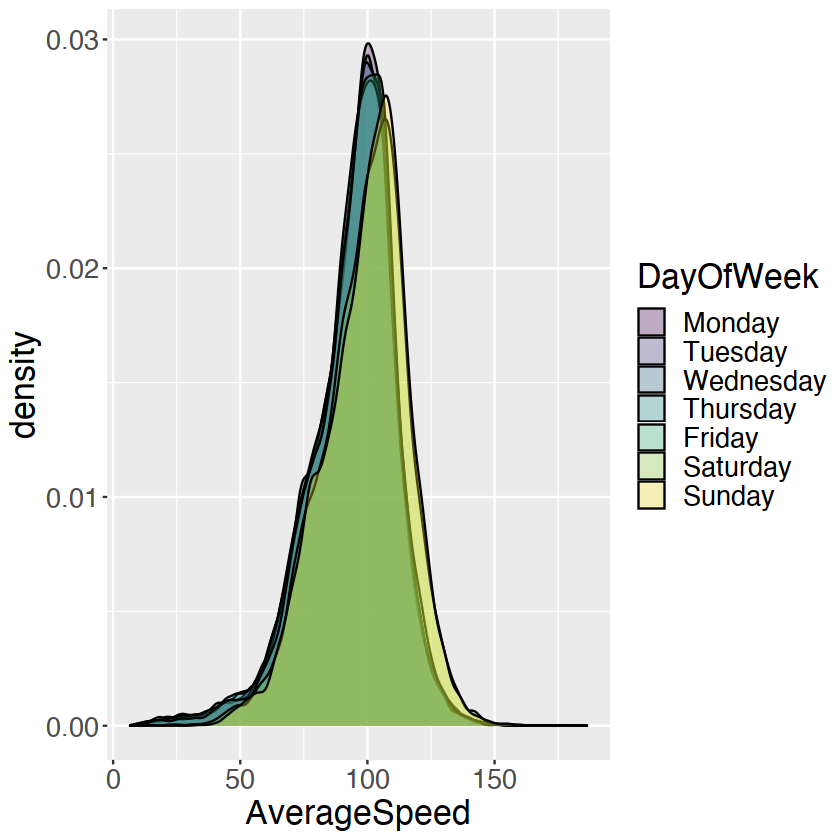

In [11]:
ggplot(probe, aes(AverageSpeed, fill=DayOfWeek))+geom_density(alpha=.3)+theme(text = element_text(size = 20))

Rozkład średnich prędkości w zależności od godziny:

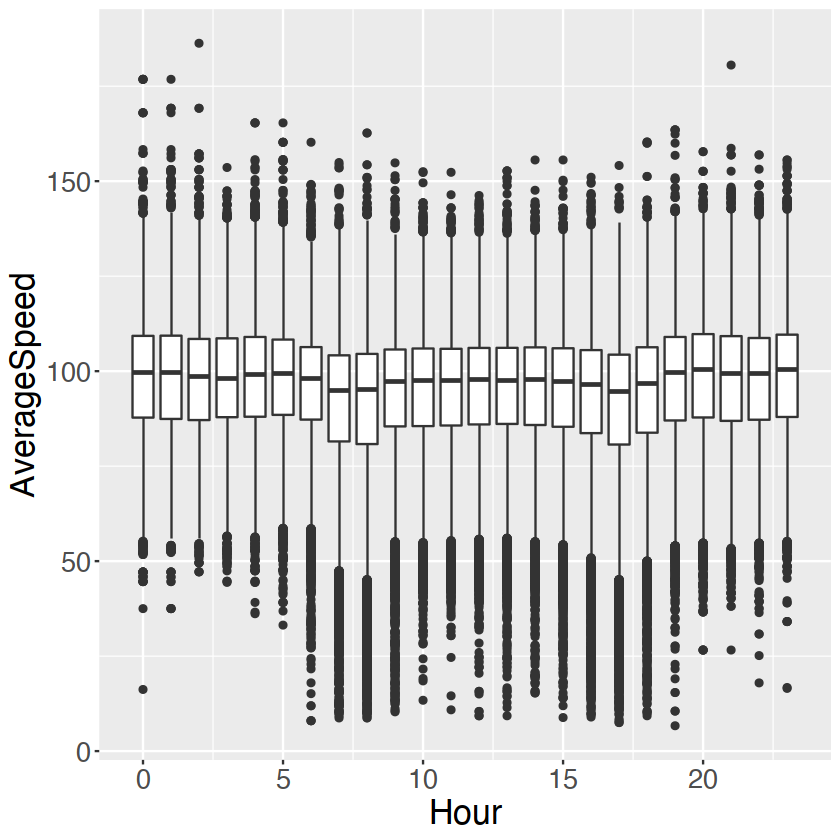

In [12]:
ggplot(probe, aes(Hour,AverageSpeed))+ geom_boxplot(aes(group = cut_width(Hour, 1)))+theme(text = element_text(size = 20))

## Klasteryzacja

Klasteryzacja dokonuje automatycznego podziału danych na klastry, czyli grupy podobnych do siebie rekordów.

Do klasteryzacji potrzebujemy narzędzi z biblioteki _e1071_:

In [13]:
require(e1071)

Ładowanie wymaganego pakietu: e1071



Chcemy podzielić rekordy względem średniej prędkości _AverageSpeed_ na trzy grupy roboczo nazwane _low_, _medium_, i _high_. Ponieważ użyty mechanizm klasteryzacji, algorytm k-średnich (https://pl.wikipedia.org/wiki/Algorytm_centroidów), jest algorytmem iteracyjnym to określamy też liczbę iteracji.

In [14]:
speeds = c('low','medium','high')
iterations <-10
columnName <-"AverageSpeed"

Algorytm k-średnich zwraca przypisanie każdej z obserwacji do klastra:

In [15]:
k<-length(speeds)
clusters <- kmeans(probe[columnName], k, iterations);
classes <- clusters$cluster

Następnie porządkujemy uzyskane wyniki tak, aby robocza nazwa klastra odpowiadała zapisanym w nim wartościom:

In [16]:
ord <-sort(clusters$centers, index.return=TRUE)

for(i in 1:k){
  classes[classes==i]  = speeds[ord$ix ==i]
}

probe$cluster = factor(classes,levels=speeds,ordered=TRUE)

Wykreślmy rozkład danych w stworzonych klastrach:

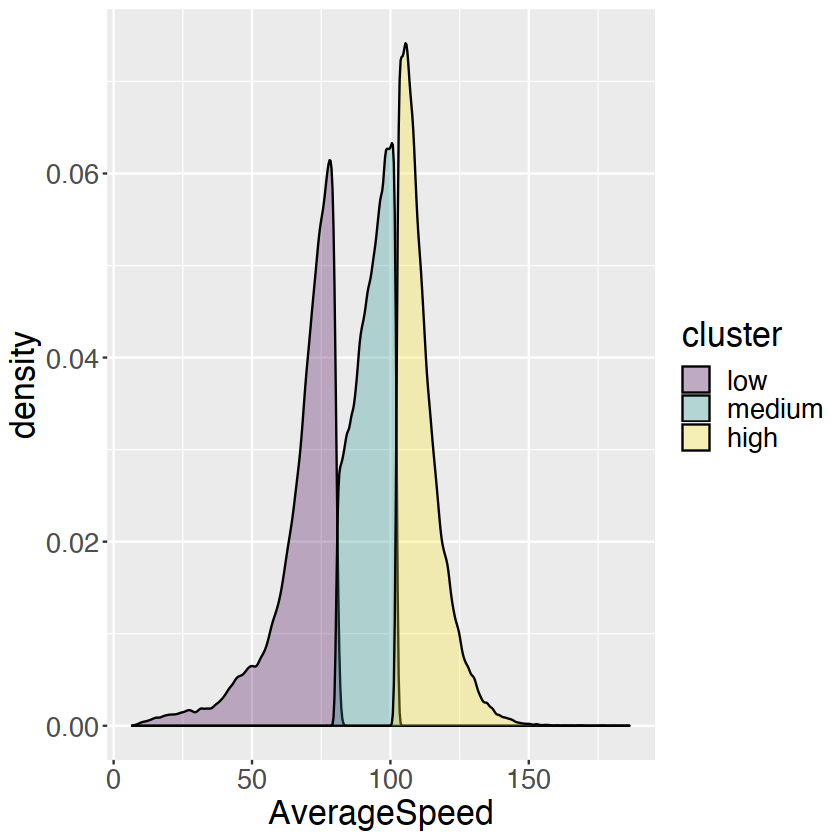

In [17]:
ggplot(probe, aes(AverageSpeed,fill=cluster))+geom_density(alpha=.3)+theme(text = element_text(size = 20))

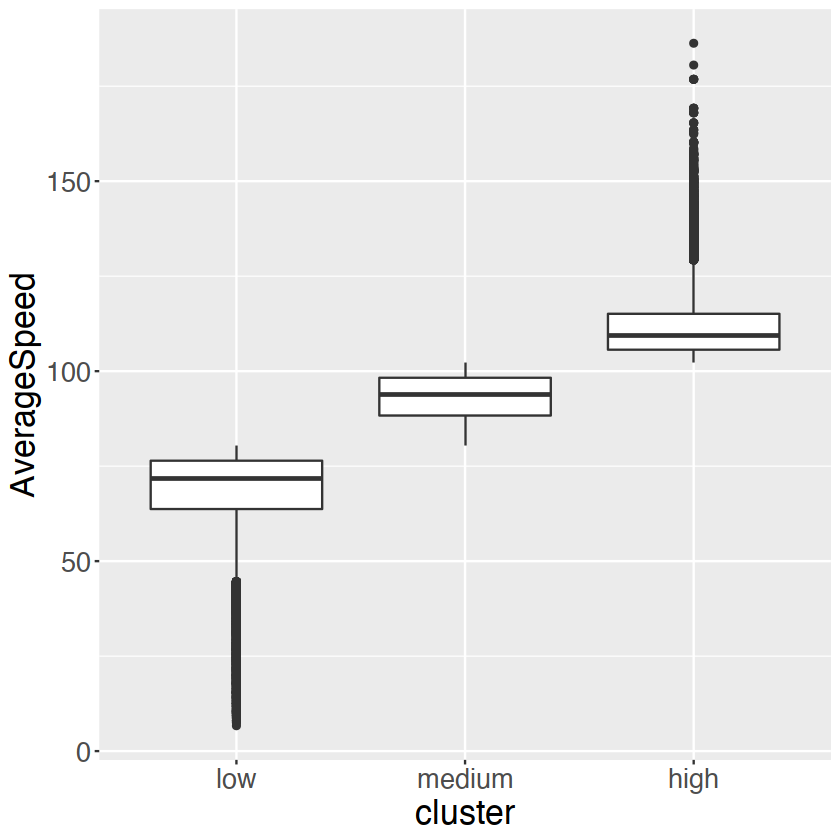

In [18]:
ggplot(probe, aes(cluster,AverageSpeed))+ geom_boxplot()+theme(text = element_text(size = 20))

Wyliczmy ich statystyki:

In [19]:
statistics <- probe %>% 
  group_by(cluster)%>%
  summarise(avg_speed = mean(AverageSpeed), 
            min_speed = min(AverageSpeed),
            max_speed = max(AverageSpeed),
            total = n())
View(statistics)

cluster,avg_speed,min_speed,max_speed,total
<ord>,<dbl>,<dbl>,<dbl>,<int>
low,67.79685,6.67,80.41,60450
medium,93.02923,80.42,102.23,146521
high,111.43155,102.24,186.30,124524


Klaster _low_ zawiera znacząco mniej obserwacji niż pozostałe klastry. Może to wpłynąć na dalszą analizę danych.

## Klasyfikacja

Klasyfikacja polega na przypisaniu obserwacji do jednej ze zdefiniowanych klas. Spróbujemy automatycznie przypisać przejazdy do jednego z trzech stworzonych klastrów.

### Drzewo decyzyjne
Do klasyfikacji użyjemy drzew decyzyjnych. Są to łatwe w interpretacji klasyfikatory, które zaimplementowano w bibliotece _rpart_, a ich wizualizację w bibliotece _rpart.plot_:

In [20]:
require(rpart)
require(rpart.plot)

Ładowanie wymaganego pakietu: rpart

Ładowanie wymaganego pakietu: rpart.plot



Spróbujemy określić do której kategorii przypisany zostanie przejazd na podstawie dnia tygodnia _DayOfWeek_, godziny _Hour_, i zatłoczenia _Flow_. Ponieważ zadanie to nie będzie łatwe, ograniczymy się do przewidywań dla pojedynczego odcinka autostrady _Link_.

In [21]:
dependentVariable <-"cluster"
independentVariables <- c('DayOfWeek','Flow','Hour');
Link = 'AL2085'
part_probe<-probe %>%
  filter(LinkRef==Link)

Tworzymy formułę objaśniającą zmienną zależną od kombinacji zmiennych niezależnych:

In [22]:
form<- paste(independentVariables, collapse = "+");
form <- as.formula(paste(dependentVariable, form, sep = " ~ "))
print(form)

cluster ~ DayOfWeek + Flow + Hour


Tworzymy drzewo decyzyjne:

In [23]:
 probe.tree <- rpart(form, method='class', data=part_probe)

Stworzone drzewo prezentuje proste reguły pozwalające na określenie czy przejazd o danej godzinie będzie szybki (w zależności od zatłoczenia odcinka):

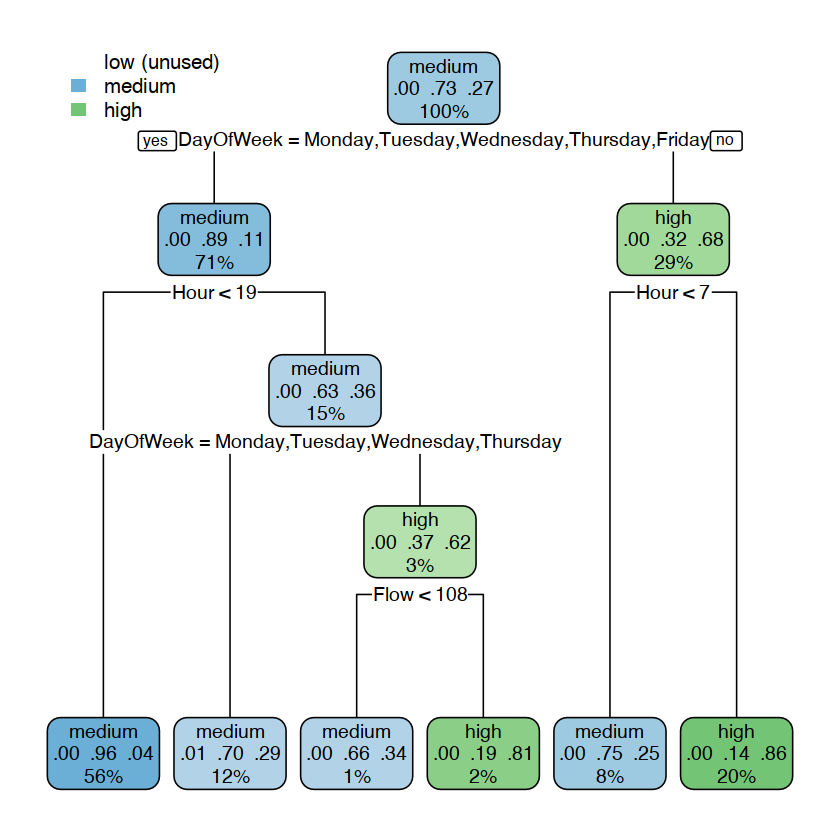

In [24]:
rpart.plot(probe.tree)

Możemy zobaczyć jak wygląda proces uczenia drzewa w zależności od jego rozłożystości:

In [25]:
printcp(probe.tree)


Classification tree:
rpart(formula = form, data = part_probe, method = "class")

Variables actually used in tree construction:
[1] DayOfWeek Flow      Hour     

Root node error: 737/2682 = 0.27479

n= 2682 

        CP nsplit rel error  xerror     xstd
1 0.383989      0   1.00000 1.00000 0.031369
2 0.153324      1   0.61601 0.61601 0.026350
3 0.013569      2   0.46269 0.46269 0.023409
4 0.010000      5   0.42198 0.43555 0.022809


Biblioteka _caret_ zawiera mechanizmy oceny klasyfikatorów:

In [26]:
require(caret)

Ładowanie wymaganego pakietu: caret

Ładowanie wymaganego pakietu: lattice



Możemy teraz ocenić jakość predykcji dokonantch przez drzewo, wyliczając macierz pomyłek i pochodne dla niej miary jakości (https://en.wikipedia.org/wiki/Sensitivity_and_specificity):

In [27]:
probe.tree.predictions <- predict(probe.tree ,part_probe, type = "class")
cm <- confusionMatrix(probe.tree.predictions, part_probe$cluster)
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction  low medium high
    low       0      0    0
    medium    6   1862  222
    high      0     83  509

Overall Statistics
                                          
               Accuracy : 0.884           
                 95% CI : (0.8713, 0.8959)
    No Information Rate : 0.7252          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6905          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: low Class: medium Class: high
Sensitivity            0.000000        0.9573      0.6963
Specificity            1.000000        0.6906      0.9575
Pos Pred Value              NaN        0.8909      0.8598
Neg Pred Value         0.997763        0.8598      0.8938
Prevalence             0.002237        0.7252      0.2726
Detection Rate         0.000000        0.6943      0.1898

Nasze drzewo poprawnie zakwalifikowało 88 procent obserwacji, ale nie potrafi poprawnie rozpoznać obiektów z klasy _low_.

Wyświetlmy macierz pomyłek klasyfikacji w postaci graficznej:

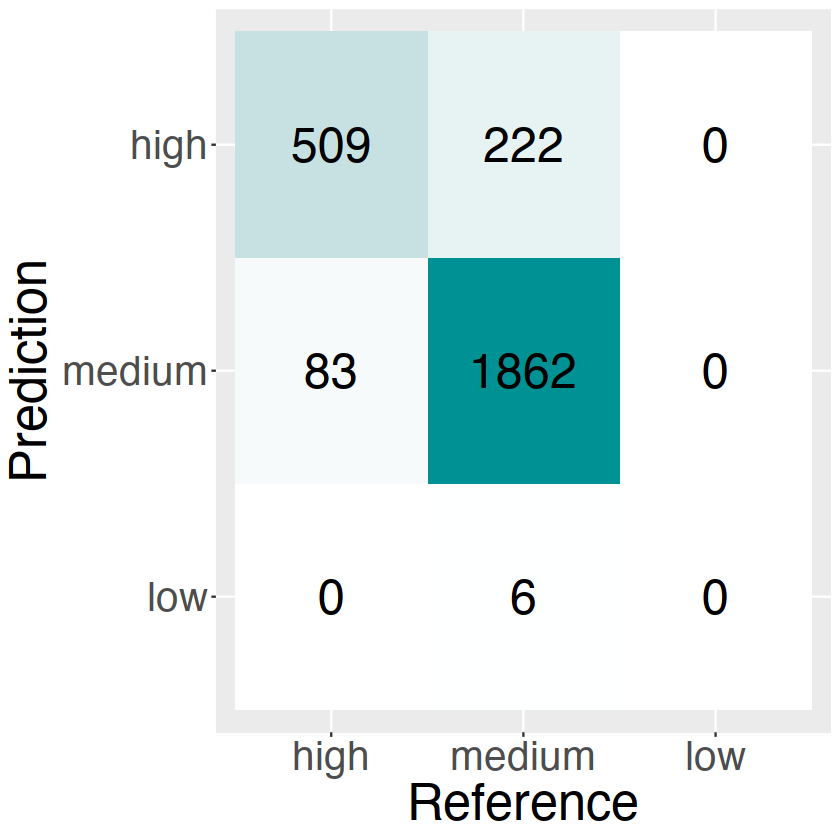

In [28]:
plt <- as.data.frame(cm$table)
plt$Prediction <- factor(plt$Prediction, levels=rev(levels(plt$Prediction)))

ggplot(plt, aes(Prediction,Reference, fill= Freq)) +
        geom_tile() + geom_text(aes(label=Freq),  size=10) +
        scale_fill_gradient(low="white", high="#009194") +
        labs(x = "Reference",y = "Prediction")+
        theme(text = element_text(size = 30), legend.position="none")       


### Testowanie drzewa

Drzewo było uczone i testowane na tych samych danych, pochodzących z lutego 2015. Sprawdzmy, czy działa równie dobrze na danych z innego okresu.

Wczytamy dane z marca 2015 roku i przypiszmy je do klastrów zgodnie z wcześniej ustalonymi regułami:

In [29]:
path = "./Data/"
filename = "MAR15.csv"
probe2 = read.csv(unzip(paste(path,filename,".zip",sep=''),filename))
probe2 <- probe2 %>%
   filter(DataQuality == 1) %>%
   filter(!is.na(Flow))%>%
   select(-LinkDescription)
probe2$DayOfWeek = weekdays(as.Date(probe2$Date))
probe2$DayOfWeek = factor(probe2$DayOfWeek,levels=dow,ordered=TRUE)
probe2$Hour = as.integer(probe2$TimePeriod*15/60)

#Labbeling of the testing set using rules from the first probe clusterisation
for(i in 1:length(speeds)){
 if(i==1){
   probe2$cluster[probe2$AverageSpeed<=statistics$max_speed[i]] = speeds[i]
 }else
    if(i==length(speeds)){
    probe2$cluster[ probe2$AverageSpeed>=statistics$min_speed[i]] = speeds[i]
    }else{
    probe2$cluster[probe2$AverageSpeed<=statistics$max_speed[i] & probe2$AverageSpeed>=statistics$min_speed[i]] = speeds[i]
  }
}
probe2$cluster = factor(probe2$cluster,levels=speeds,ordered=TRUE)


In [30]:
head(probe2)

,LinkRef,Date,TimePeriod,AverageJT,AverageSpeed,DataQuality,LinkLength,Flow,DayOfWeek,Hour,cluster
,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<ord>,<int>,<ord>
1,AL100,2015-03-01 00:00:00,0,138.26,117.43,1,4.51,31.0,Sunday,0,high
2,AL100,2015-03-01 00:00:00,1,138.26,117.43,1,4.51,32.5,Sunday,0,high
3,AL100,2015-03-01 00:00:00,2,138.26,117.43,1,4.51,26.5,Sunday,0,high
4,AL100,2015-03-01 00:00:00,3,138.26,117.43,1,4.51,23.5,Sunday,0,high
5,AL100,2015-03-01 00:00:00,4,138.26,117.43,1,4.51,18.0,Sunday,1,high
6,AL100,2015-03-01 00:00:00,27,193.03,84.11,1,4.51,36.0,Sunday,6,medium


Sprawdzmy, jak wcześniej utworzone drzewo sprawdzi się na nowych danych:

In [31]:
dependentVariable <-"cluster"
independentVariables <- c('DayOfWeek','Flow','Hour')

part_probe2<-probe2 %>%
  filter(LinkRef==Link)
probe2.tree.predictions <- predict(probe.tree ,part_probe2, type = "class")
confusionMatrix(probe2.tree.predictions, part_probe2$cluster)

Confusion Matrix and Statistics

          Reference
Prediction  low medium high
    low       0      0    0
    medium   11   1930  366
    high      1     66  589

Overall Statistics
                                          
               Accuracy : 0.8502          
                 95% CI : (0.8368, 0.8628)
    No Information Rate : 0.6736          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6292          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: low Class: medium Class: high
Sensitivity             0.00000        0.9669      0.6168
Specificity             1.00000        0.6101      0.9666
Pos Pred Value              NaN        0.8366      0.8979
Neg Pred Value          0.99595        0.8994      0.8414
Prevalence              0.00405        0.6736      0.3223
Detection Rate          0.00000        0.6514      0.1988

Drzewo uzyskało skuteczność 85 procent, niewiele mniejszą niż dla wcześniejszych danych. Oznacza to, że posiada ono zdolność generalizacji, czyli poprawnego działania dla nowych danych.

## Regresja

Zadanie regresji polega na przypisaniu do obserwacji pewnej zmiennej ciągłej.

### Las losowy

Las losowy jest zbiorem drzew, które w procesie głosowania wybierają wspólne rozwiązanie danego problemu. Decyzje lasu nie są tak łatwo interpretowalne jak decyzje pojedynczego drzewa, ale jego możliwości są znacznie większe. Las losowy jest zaimplementowany w bibliotece _randomForest_.

In [32]:
 require(randomForest)

Ładowanie wymaganego pakietu: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Dołączanie pakietu: ‘randomForest’


Następujący obiekt został zakryty z ‘package:ggplot2’:

    margin


Następujący obiekt został zakryty z ‘package:dplyr’:

    combine




Chcemy estymować średnią prędkość _AverageSpeed_ na podstawie takich czynników jak dzień tygodnia _DayOfWeek_, natężenie ruchu _Flow_, godzina przejazdu _Hour_, i długość odcinka _LinkLength_.

In [33]:
dependentVariable <-"AverageSpeed"
independentVariables <- c('DayOfWeek','Flow','Hour','LinkLength')

form<- paste(independentVariables, collapse = "+");
form <- as.formula(paste(dependentVariable, form, sep = " ~ "))
print(form)

AverageSpeed ~ DayOfWeek + Flow + Hour + LinkLength


Zbudujemy las złożony z 10 drzew losowych:

In [34]:
nTree = 10
probe.rf <- randomForest(form,probe,ntree=nTree,importance=TRUE)


In [35]:
probe.rf.predictions <- predict(probe.rf ,probe)
size = 500
df <- data.frame(
   y = c(probe$AverageSpeed[1:size], probe.rf.predictions[1:size]),
   x = c(1:size,1:size),
   probe = c(rep('speed', size), rep('estimation', size)) 
 )

Saving 7 x 7 in image



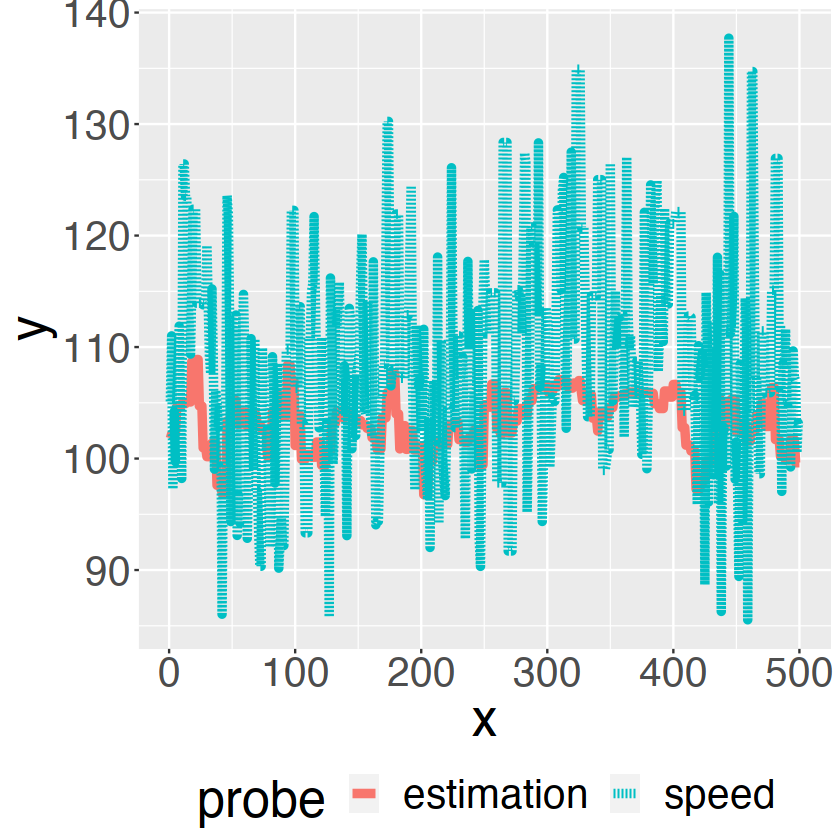

In [36]:
ggplot(df, aes(x, y, colour = probe, linetype=probe))+ geom_line(size=2)+theme(text = element_text(size = 30), legend.position="bottom")
ggsave("regression.pdf")

Wyliczmy średni błąd dla danych uczących:

In [37]:
probe.rf.predictions <- predict(probe.rf ,probe)
probe.rf.errors <- abs(probe.rf.predictions-probe$AverageSpeed)
print(mean(probe.rf.errors))

[1] 9.5102


Wyliczmy średni błąd dla danych testowych:

In [38]:
probe2.rf.predictions <- predict(probe.rf ,probe2)
probe2.rf.errors <- abs(probe2.rf.predictions-probe2$AverageSpeed)
print(mean(probe2.rf.errors))

[1] 14.11586


W celu porównania błędów dla obydwu zbiorów zestawimy je w jedną tabelę:

In [39]:
df <- data.frame(
   x = c(probe.rf.errors, probe2.rf.errors),
   probe = c(rep('learning', length(probe.rf.errors)), rep('testing', length(probe2.rf.errors))) 
 )

Porównamy rozkład błędów stosując skumulowaną funkcję dystrybucji:

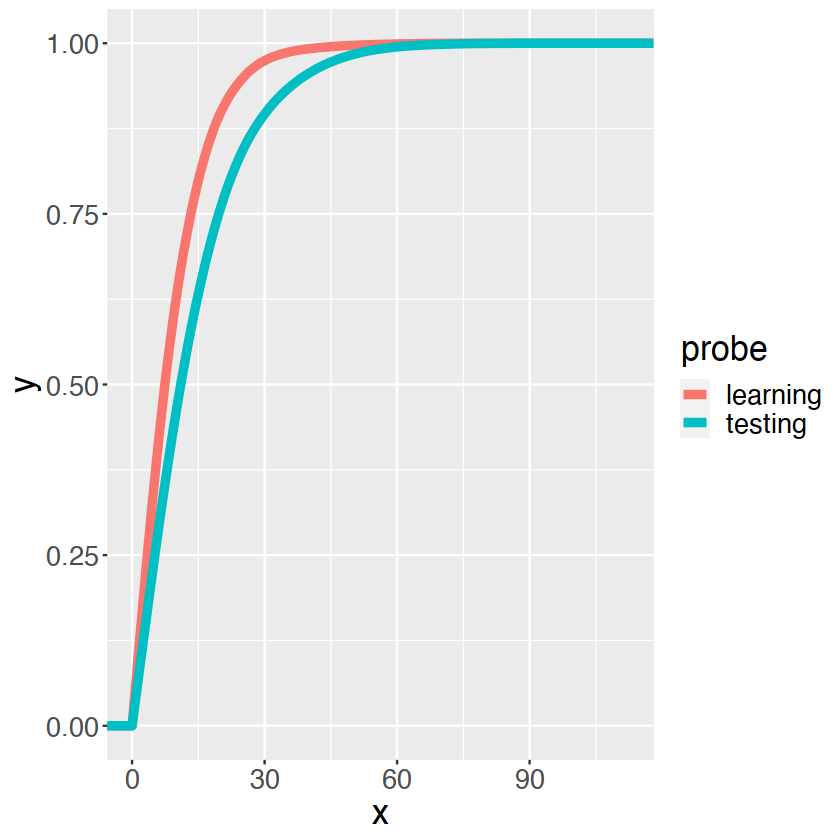

In [40]:
 ggplot(df, aes(x, colour = probe)) + stat_ecdf(size=2)+theme(text = element_text(size = 20))

In [41]:
median(probe2.rf.errors)

[1] 11.02117

In [42]:
median(probe.rf.errors)

[1] 7.428472

Nie da się łatwo analizować reguł tworzonych przez las losowy, ale możemy analizować, które cechy były najważniejsze w kontekście minimalizacji błędu.

In [43]:
importance(probe.rf)

,%IncMSE,IncNodePurity
DayOfWeek,19.68183,2144621
Flow,14.55182,6801319
Hour,16.90187,3462004
LinkLength,13.96654,26696424
